# Stage 3 Full Run: Baseline vs Elementwise (full length, lr=0.00468, 3 seeds)

In [1]:
%%bash
source /workspace/ese-3060-project/.venv/bin/activate
python -m ipykernel install --user --name ese3060-venv --display-name "ese3060 venv"
echo "Kernel installed."

Installed kernelspec ese3060-venv in /root/.local/share/jupyter/kernels/ese3060-venv
Kernel installed.


In [2]:
from pathlib import Path
import os, subprocess, json, glob, re
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%cd /workspace/ese-3060-project

# Detect project root: prefer PROJ_ROOT env, else repo root (parent if running from notebooks/)
cwd = Path.cwd().expanduser().resolve()
default_root = cwd.parent if cwd.name == 'notebooks' else cwd
PROJ_ROOT = Path(os.environ.get('PROJ_ROOT', default_root)).expanduser().resolve()
SCRIPT_PATH = PROJ_ROOT / 'train_gpt.py'
RESULTS = PROJ_ROOT / 'experiments' / 'results_stage3.csv'
RESULTS_ALL = PROJ_ROOT / 'experiments' / 'results.csv'
CURVES_CSV = PROJ_ROOT / 'experiments' / 'log_curves_stage3.csv'
LOG_DIR = PROJ_ROOT / 'logs'
SPLITTER = PROJ_ROOT / 'scripts' / 'split_results.py'

# If stage-specific results not found, fall back to aggregated
if not RESULTS.exists() and RESULTS_ALL.exists():
    RESULTS = RESULTS_ALL

print('Project root:', PROJ_ROOT)
print('Results:', RESULTS)
print('Log dir:', LOG_DIR)
print('Curves CSV:', CURVES_CSV)

/workspace/ese-3060-project
Project root: /workspace/ese-3060-project
Results: /workspace/ese-3060-project/experiments/results_stage3.csv
Log dir: /workspace/ese-3060-project/logs
Curves CSV: /workspace/ese-3060-project/experiments/log_curves_stage3.csv


In [ ]:
# Runtime knobs
NPROC = None                # auto-detect GPU count if None
LR = 0.00468
SEEDS = [1337, 2337, 3337]  # 3 seeds per config
NUM_ITER = 5100             # full length
WARMUP_ITERS = 0
WARMDOWN_ITERS = 1450
VAL_EVERY = 125
CONFIGS = {
    "baseline":    {"ATTNGATE": "none",        "GATEPOS": "sdpa", "GATEACT": "sigmoid"},
    "elementwise": {"ATTNGATE": "elementwise", "GATEPOS": "sdpa", "GATEACT": "sigmoid"},
}
TORCHRUN = "torchrun"
LAUNCH = False             # set True to actually run

# torchrun helpers
if NPROC is None:
    try:
        gpu_count = int(subprocess.check_output("nvidia-smi --list-gpus | wc -l", shell=True).decode().strip())
    except Exception:
        gpu_count = 0
    NPROC = max(gpu_count, 1)

assert SCRIPT_PATH.exists(), f"Missing train script: {SCRIPT_PATH}"

def run_job(name, cfg, seed):
    env = os.environ.copy()
    env.update({
        "ATTNGATE": cfg["ATTNGATE"],
        "GATEPOS": cfg["GATEPOS"],
        "GATEACT": cfg["GATEACT"],
        "LR": str(LR),
        "SEED": str(seed),
        "NUM_ITERATIONS": str(NUM_ITER),
        "WARMUP_ITERS": str(WARMUP_ITERS),
        "WARMDOWN_ITERS": str(WARMDOWN_ITERS),
        "VAL_EVERY": str(VAL_EVERY),
    })
    cmd = [TORCHRUN, "--standalone", f"--nproc_per_node={NPROC}", str(SCRIPT_PATH)]
    print(f"\n>>> Launching {name} seed={seed} lr={LR:.5f} nproc={NPROC}")
    if not LAUNCH:
        return 0
    proc = subprocess.run(cmd, env=env)
    if proc.returncode != 0:
        raise RuntimeError(f"Run failed: {name} seed {seed} rc={proc.returncode}")

for cfg_name, cfg_env in CONFIGS.items():
    for seed in SEEDS:
        run_job(cfg_name, cfg_env, seed)

if LAUNCH:
    # Refresh splits (stage1=1500, stage2=800; stage3 remains in main results unless you add a stage3 filter later)
    subprocess.run(["python", str(SPLITTER), "--stage1-iters", "1500", "--stage2-iters", "800"], check=False)

print("Done (LAUNCH=" + str(LAUNCH) + ")")


>>> Launching baseline seed=1337 lr=0.00468 nproc=8


W1209 20:00:19.178000 840 torch/distributed/run.py:774] 
W1209 20:00:19.178000 840 torch/distributed/run.py:774] *****************************************
W1209 20:00:19.178000 840 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1209 20:00:19.178000 840 torch/distributed/run.py:774] *****************************************


using device: cuda:0
using device: cuda:2
using device: cuda:6
using device: cuda:7
using device: cuda:4
using device: cuda:1
using device: cuda:5
using device: cuda:3
Training DataLoader: total number of tokens: 900000000 across 9 files
Validation DataLoader: total number of tokens: 100000000 across 1 files
step:0/5100 val_loss:16.0297 train_time:152ms step_avg:nanms
step:1/5100 train_loss:16.0221 train_time:77942ms step_avg:nanms
step:2/5100 train_loss:9.6009 train_time:81765ms step_avg:nanms
step:3/5100 train_loss:8.7084 train_time:82061ms step_avg:nanms
step:4/5100 train_loss:7.9103 train_time:82354ms step_avg:nanms
step:5/5100 train_loss:7.6187 train_time:82645ms step_avg:nanms
step:6/5100 train_loss:7.6991 train_time:82937ms step_avg:nanms
step:7/5100 train_loss:7.3375 train_time:83229ms step_avg:nanms
step:8/5100 train_loss:7.5098 train_time:83518ms step_avg:nanms
step:9/5100 train_loss:7.2041 train_time:83809ms step_avg:nanms
step:10/5100 train_loss:7.1628 train_time:84099ms st

W1209 20:28:55.761000 41756 torch/distributed/run.py:774] 
W1209 20:28:55.761000 41756 torch/distributed/run.py:774] *****************************************
W1209 20:28:55.761000 41756 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1209 20:28:55.761000 41756 torch/distributed/run.py:774] *****************************************


using device: cuda:6
using device: cuda:1
using device: cuda:7
using device: cuda:5
using device: cuda:2
using device: cuda:4
using device: cuda:0
using device: cuda:3
Training DataLoader: total number of tokens: 900000000 across 9 files
Validation DataLoader: total number of tokens: 100000000 across 1 files
step:0/5100 val_loss:16.0277 train_time:152ms step_avg:nanms
step:1/5100 train_loss:16.0220 train_time:58168ms step_avg:nanms
step:2/5100 train_loss:9.5656 train_time:60099ms step_avg:nanms
step:3/5100 train_loss:8.5951 train_time:60393ms step_avg:nanms
step:4/5100 train_loss:8.0979 train_time:60683ms step_avg:nanms
step:5/5100 train_loss:7.6192 train_time:60973ms step_avg:nanms
step:6/5100 train_loss:7.7639 train_time:61262ms step_avg:nanms
step:7/5100 train_loss:7.2869 train_time:61552ms step_avg:nanms
step:8/5100 train_loss:7.6173 train_time:61842ms step_avg:nanms
step:9/5100 train_loss:7.4692 train_time:62131ms step_avg:nanms
step:10/5100 train_loss:7.3093 train_time:62420ms st

W1209 20:56:40.148000 47186 torch/distributed/run.py:774] 
W1209 20:56:40.148000 47186 torch/distributed/run.py:774] *****************************************
W1209 20:56:40.148000 47186 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1209 20:56:40.148000 47186 torch/distributed/run.py:774] *****************************************


using device: cuda:5
using device: cuda:2
using device: cuda:4
using device: cuda:7
using device: cuda:0
using device: cuda:1
using device: cuda:3
using device: cuda:6
Training DataLoader: total number of tokens: 900000000 across 9 files
Validation DataLoader: total number of tokens: 100000000 across 1 files
step:0/5100 val_loss:15.9885 train_time:143ms step_avg:nanms
step:1/5100 train_loss:15.9909 train_time:63830ms step_avg:nanms
step:2/5100 train_loss:9.5833 train_time:64564ms step_avg:nanms
step:3/5100 train_loss:8.5964 train_time:64858ms step_avg:nanms
step:4/5100 train_loss:8.0033 train_time:65147ms step_avg:nanms
step:5/5100 train_loss:7.7117 train_time:65437ms step_avg:nanms
step:6/5100 train_loss:7.8209 train_time:65726ms step_avg:nanms
step:7/5100 train_loss:7.5100 train_time:66015ms step_avg:nanms
step:8/5100 train_loss:7.9107 train_time:66305ms step_avg:nanms
step:9/5100 train_loss:7.4410 train_time:66594ms step_avg:nanms
step:10/5100 train_loss:7.2892 train_time:66883ms st

W1209 21:24:24.136000 50627 torch/distributed/run.py:774] 
W1209 21:24:24.136000 50627 torch/distributed/run.py:774] *****************************************
W1209 21:24:24.136000 50627 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1209 21:24:24.136000 50627 torch/distributed/run.py:774] *****************************************


using device: cuda:5
using device: cuda:2
using device: cuda:4
using device: cuda:3
using device: cuda:1
using device: cuda:7
using device: cuda:0
using device: cuda:6
Training DataLoader: total number of tokens: 900000000 across 9 files
Validation DataLoader: total number of tokens: 100000000 across 1 files
step:0/5100 val_loss:16.0015 train_time:161ms step_avg:nanms
step:1/5100 train_loss:16.0007 train_time:80570ms step_avg:nanms
step:2/5100 train_loss:9.5956 train_time:81194ms step_avg:nanms
step:3/5100 train_loss:8.5041 train_time:81510ms step_avg:nanms
step:4/5100 train_loss:7.8438 train_time:81821ms step_avg:nanms
step:5/5100 train_loss:7.5682 train_time:82131ms step_avg:nanms
step:6/5100 train_loss:7.5807 train_time:82441ms step_avg:nanms
step:7/5100 train_loss:7.0228 train_time:82750ms step_avg:nanms
step:8/5100 train_loss:7.3440 train_time:83060ms step_avg:nanms
step:9/5100 train_loss:7.0497 train_time:83369ms step_avg:nanms
step:10/5100 train_loss:6.9042 train_time:83678ms st

W1209 21:54:51.108000 101769 torch/distributed/run.py:774] 
W1209 21:54:51.108000 101769 torch/distributed/run.py:774] *****************************************
W1209 21:54:51.108000 101769 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1209 21:54:51.108000 101769 torch/distributed/run.py:774] *****************************************


using device: cuda:7
using device: cuda:1
using device: cuda:3
using device: cuda:0
using device: cuda:2
using device: cuda:5
using device: cuda:6
using device: cuda:4
Training DataLoader: total number of tokens: 900000000 across 9 files
Validation DataLoader: total number of tokens: 100000000 across 1 files
step:0/5100 val_loss:16.0092 train_time:162ms step_avg:nanms
step:1/5100 train_loss:16.0083 train_time:56216ms step_avg:nanms
step:2/5100 train_loss:9.6125 train_time:57093ms step_avg:nanms
step:3/5100 train_loss:8.5689 train_time:57406ms step_avg:nanms
step:4/5100 train_loss:7.8638 train_time:57715ms step_avg:nanms
step:5/5100 train_loss:7.5258 train_time:58024ms step_avg:nanms
step:6/5100 train_loss:7.5371 train_time:58332ms step_avg:nanms
step:7/5100 train_loss:7.0057 train_time:58640ms step_avg:nanms
step:8/5100 train_loss:7.3383 train_time:58948ms step_avg:nanms
step:9/5100 train_loss:7.0875 train_time:59256ms step_avg:nanms
step:10/5100 train_loss:6.8344 train_time:59564ms st

W1209 22:24:21.200000 108401 torch/distributed/run.py:774] 
W1209 22:24:21.200000 108401 torch/distributed/run.py:774] *****************************************
W1209 22:24:21.200000 108401 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1209 22:24:21.200000 108401 torch/distributed/run.py:774] *****************************************


using device: cuda:0
using device: cuda:3
using device: cuda:7
using device: cuda:4
Training DataLoader: total number of tokens: 900000000 across 9 files
Validation DataLoader: total number of tokens: 100000000 across 1 files
using device: cuda:1
using device: cuda:2
using device: cuda:6
using device: cuda:5
step:0/5100 val_loss:16.0462 train_time:96ms step_avg:nanms
step:1/5100 train_loss:16.0481 train_time:47364ms step_avg:nanms
step:2/5100 train_loss:9.5852 train_time:48140ms step_avg:nanms
step:3/5100 train_loss:8.5181 train_time:48451ms step_avg:nanms
step:4/5100 train_loss:7.9544 train_time:48760ms step_avg:nanms
step:5/5100 train_loss:7.5512 train_time:49068ms step_avg:nanms
step:6/5100 train_loss:7.3152 train_time:49376ms step_avg:nanms
step:7/5100 train_loss:6.9840 train_time:49684ms step_avg:nanms
step:8/5100 train_loss:7.5670 train_time:49992ms step_avg:nanms
step:9/5100 train_loss:7.0202 train_time:50300ms step_avg:nanms
step:10/5100 train_loss:6.8185 train_time:50609ms ste

Traceback (most recent call last):
  File "/workspace/ese-3060-project/scripts/split_results.py", line 20, in <module>
    import pandas as pd
ModuleNotFoundError: No module named 'pandas'


In [4]:
# Load results
if RESULTS.exists():
    df = pd.read_csv(RESULTS)
elif RESULTS_ALL.exists():
    df = pd.read_csv(RESULTS_ALL)
    # filter best-effort for stage3 params
    df = df[(df.get('num_iterations',0)==NUM_ITER) & (df.get('learning_rate',0).round(5)==LR) & (df.get('warmdown_iters',0)==WARMDOWN_ITERS)]
else:
    df = pd.DataFrame()
df.head() if not df.empty else df

,run_id,date,git_commit,seed,attn_gate,gate_pos,gate_act,learning_rate,batch_size,device_batch_size,...,num_iterations,warmdown_iters,final_val_loss,best_val_loss,train_time_ms,ms_per_step,gpu_name,n_gpus,runpod_instance,notes
0,cadd9fa4-5d2f-4de3-845e-60fed27b6c1e,2025-12-09 20:28:49,08372c9882847a472c8ebf0e9b5c6c36533ad198,1337,none,sdpa,sigmoid,0.00468,512,64,...,5100,1450,3.291986,3.291986,1.476861e+06,290.092610,NVIDIA RTX PRO 6000 Blackwell Server Edition,8,unknown,NaN
1,bf82d241-6aa4-4dc7-871f-02a6987de4b7,2025-12-09 20:56:34,08372c9882847a472c8ebf0e9b5c6c36533ad198,2337,none,sdpa,sigmoid,0.00468,512,64,...,5100,1450,3.293929,3.293929,1.476246e+06,289.971637,NVIDIA RTX PRO 6000 Blackwell Server Edition,8,unknown,NaN
2,ea0310de-8c31-49bd-bcfd-49c15bde32fa,2025-12-09 21:24:18,08372c9882847a472c8ebf0e9b5c6c36533ad198,3337,none,sdpa,sigmoid,0.00468,512,64,...,5100,1450,3.292181,3.292181,1.477536e+06,290.225053,NVIDIA RTX PRO 6000 Blackwell Server Edition,8,unknown,NaN
3,4078749c-292d-4965-bd87-3bbf56576c8c,2025-12-09 21:54:44,08372c9882847a472c8ebf0e9b5c6c36533ad198,1337,elementwise,sdpa,sigmoid,0.00468,512,64,...,5100,1450,3.271069,3.271069,1.570615e+06,308.508160,NVIDIA RTX PRO 6000 Blackwell Server Edition,8,unknown,NaN
4,51c387ed-2da5-456a-b468-2cb1a66d02d8,2025-12-09 22:24:14,08372c9882847a472c8ebf0e9b5c6c36533ad198,2337,elementwise,sdpa,sigmoid,0.00468,512,64,...,5100,1450,3.272427,3.272427,1.570852e+06,308.554717,NVIDIA RTX PRO 6000 Blackwell Server Edition,8,unknown,NaN


,attn_gate,runs,mean_best_val,std_best_val,mean_final_val,mean_ms_step,std_ms_step
0,elementwise,3,3.272271,0.001131,3.272271,308.569180,0.069392
1,none,3,3.292699,0.001070,3.292699,290.096433,0.126751


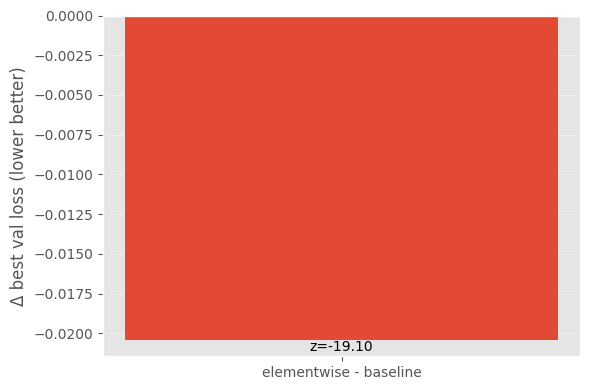

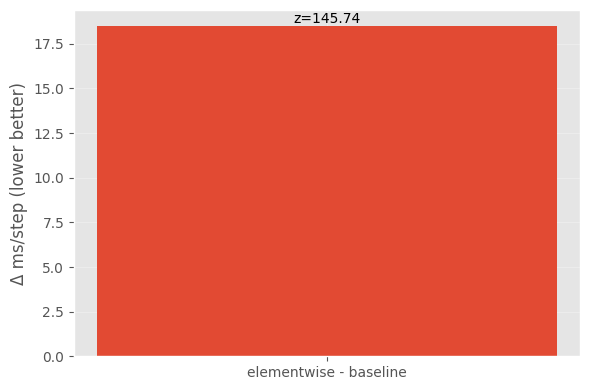

In [5]:
# Aggregate comparison with deltas (elementwise vs baseline)
if not df.empty:
    agg = df.groupby('attn_gate').agg(
        runs=('run_id','count'),
        mean_best_val=('best_val_loss','mean'),
        std_best_val=('best_val_loss','std'),
        mean_final_val=('final_val_loss','mean'),
        mean_ms_step=('ms_per_step','mean'),
        std_ms_step=('ms_per_step','std'),
    ).reset_index()
    display(agg)
    if 'none' in agg['attn_gate'].values and 'elementwise' in agg['attn_gate'].values:
        base = agg.set_index('attn_gate').loc['none']
        elem = agg.set_index('attn_gate').loc['elementwise']
        delta_loss = elem['mean_best_val'] - base['mean_best_val']
        std_loss = base['std_best_val'] if pd.notna(base['std_best_val']) and base['std_best_val']!=0 else float('nan')
        z_loss = delta_loss / std_loss if std_loss==std_loss and std_loss!=0 else float('nan')
        delta_ms = elem['mean_ms_step'] - base['mean_ms_step']
        std_ms = base['std_ms_step'] if pd.notna(base['std_ms_step']) and base['std_ms_step']!=0 else float('nan')
        z_ms = delta_ms / std_ms if std_ms==std_ms and std_ms!=0 else float('nan')

        fig, ax = plt.subplots(figsize=(6,4))
        ax.bar([0], [delta_loss])
        ax.set_xticks([0]); ax.set_xticklabels(['elementwise - baseline'])
        ax.set_ylabel('Δ best val loss (lower better)')
        ax.bar_label(ax.containers[0], labels=[f'z={z_loss:.2f}' if z_loss==z_loss else 'z=NA'])
        ax.grid(True, alpha=0.3)
        plt.tight_layout(); plt.show()

        fig, ax = plt.subplots(figsize=(6,4))
        ax.bar([0], [delta_ms])
        ax.set_xticks([0]); ax.set_xticklabels(['elementwise - baseline'])
        ax.set_ylabel('Δ ms/step (lower better)')
        ax.bar_label(ax.containers[0], labels=[f'z={z_ms:.2f}' if z_ms==z_ms else 'z=NA'])
        ax.grid(True, alpha=0.3)
        plt.tight_layout(); plt.show()
    else:
        print('Baseline or elementwise missing; cannot compute deltas.')
else:
    print('No stage3 results found; ensure runs are logged.')

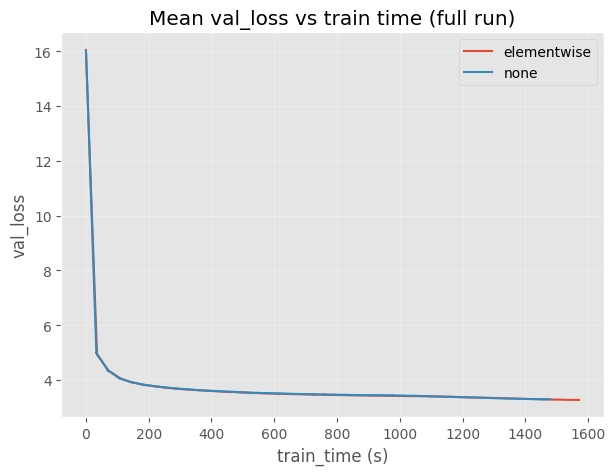

In [6]:
# Parse logs and plot mean curves per attn_gate
VAL_RE = re.compile(r"step:(\d+)/(\d+).*val_loss:([0-9.]+).*train_time:(\d+)ms")
rows = []
for path in LOG_DIR.glob('*.txt') if LOG_DIR.exists() else []:
    rid = path.stem
    cfg = df[df['run_id']==rid]
    if cfg.empty:
        continue
    cfg = cfg.iloc[0]
    with open(path) as f:
        for line in f:
            m = VAL_RE.search(line)
            if m:
                step = int(m.group(1))
                vloss = float(m.group(3))
                t_ms = int(m.group(4))
                rows.append({
                    'run_id': rid,
                    'step': step,
                    'val_loss': vloss,
                    'train_time_ms': t_ms,
                    'attn_gate': cfg['attn_gate'],
                    'learning_rate': cfg['learning_rate'],
                })
curves = pd.DataFrame(rows)

if not curves.empty:
    fig, ax = plt.subplots(figsize=(7,5))
    for gate, sub in curves.groupby('attn_gate'):
        sub = sub.sort_values('train_time_ms')
        mean_curve = sub.groupby('train_time_ms')['val_loss'].mean().reset_index()
        ax.plot(mean_curve['train_time_ms']/1000.0, mean_curve['val_loss'], label=gate)
    ax.set_xlabel('train_time (s)')
    ax.set_ylabel('val_loss')
    ax.set_title('Mean val_loss vs train time (full run)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()
else:
    print('No curves to plot.')

In [7]:
# Export curves
if not curves.empty:
    CURVES_CSV.parent.mkdir(parents=True, exist_ok=True)
    curves.to_csv(CURVES_CSV, index=False)
    print(f"Saved curves to {CURVES_CSV}")
else:
    print('curves is empty; nothing to export.')

Saved curves to /workspace/ese-3060-project/experiments/log_curves_stage3.csv
